## Pre-selection with DeepMD

In this example we use the `model_devi.out` output by LAMMPS+DeepMD to perform the pre-selection.

In [1]:
import numpy as np
import pandas as pd
from ase.io import read,write
import matplotlib.pyplot as plt

In [ ]:
traj = read("traj.lammps",index=":") 

# load the file model_devi.out into a pandas dataframe
cols = "step, max_devi_v, min_devi_v, avg_devi_v, max_devi_f, min_devi_f, avg_devi_f".split(", ")

df = pd.read_csv("model_devi.out",sep="      ", names=cols)

df

/tmp/ipykernel_129651/3360275389.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("model_devi.out",sep="      ", names=cols)


,step,max_devi_v,min_devi_v,avg_devi_v,max_devi_f,min_devi_f,avg_devi_f
0,500150,0.015767,0.001235,0.007306,0.082476,0.001817,0.017957
1,500160,0.016342,0.000785,0.007765,0.101508,0.001164,0.017808
2,500170,0.015332,0.001125,0.007151,0.113803,0.001184,0.018453
3,500180,0.013991,0.000286,0.006608,0.105961,0.001213,0.019211
4,500190,0.014043,0.000298,0.006409,0.090745,0.001639,0.019011
5,500200,0.016279,0.001148,0.007479,0.063454,0.001477,0.018332
6,500210,0.014677,0.000801,0.006674,0.057382,0.000378,0.018343
7,500220,0.014671,0.001020,0.006933,0.062450,0.000849,0.018260
8,500230,0.013726,0.000484,0.005832,0.059674,0.001559,0.017981
9,500240,0.015538,0.001088,0.006874,0.072700,0.001853,0.018384


Note: this example assumes that you have already run a MD simulation with LAMMPS+DeepMD and that you have the `model_devi.out` file available. Here the file contains only 12 frames for demonstration purposes.

<Axes: xlabel='step'>

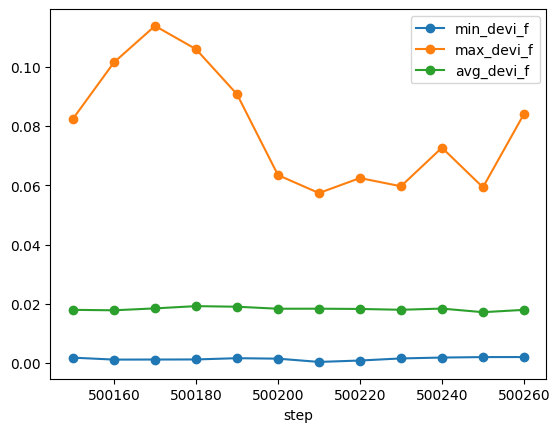

In [7]:
# plt uncertainty
fig,ax = plt.subplots()
df.plot('step','min_devi_f',marker='o',ax=ax)
df.plot('step','max_devi_f',marker='o',ax=ax)
df.plot('step','avg_devi_f',marker='o',ax=ax)

Filter based on uncertainty threshold

In [8]:
for i,atoms in enumerate(traj):
    atoms.info.update(df.iloc[i].to_dict())
    atoms.info['uncertainty'] = atoms.info['max_devi_f']

In [9]:
def filter_by_uncertainty(traj,uncertainty=None,threshold=0.1,max_threshold=0.5):
    """
    Filter atoms objects in `traj` by uncertainty.

    Parameters
    ----------
    traj : list
        List of atoms objects
    uncertainty : array_like
        Uncertainty of each frame in `traj`, if not given use atoms.info['uncertainty']
    threshold : float
        Min uncertainty that trigger selection
    max_threshold : float, optional
        Max uncertainty to include.

    Returns
    -------
    filtered_traj : list
        List of atoms objects with uncertainty > `threshold`
        and uncertainty < `max_threshold`
    """
    if uncertainty is None:
        uncertainty = np.array([atoms.info['uncertainty'] for atoms in traj])
    sel = (uncertainty>threshold) & (uncertainty<max_threshold)
    return [atoms for s,atoms in zip(sel,traj) if s]

In [10]:
threshold = 0.1

traj_filter = filter_by_uncertainty(traj,threshold=threshold)
print('--> Filter by uncertainty:',len(traj_filter),'\n')

--> Filter by uncertainty: 3 



Save the trajectory to be used as input for DEAL

In [10]:
write('traj_preselection.xyz',traj_filter)